うまく実装するとこんな画像も作れる生成AIの技術です。Diffusionモデルという技術を使っています。
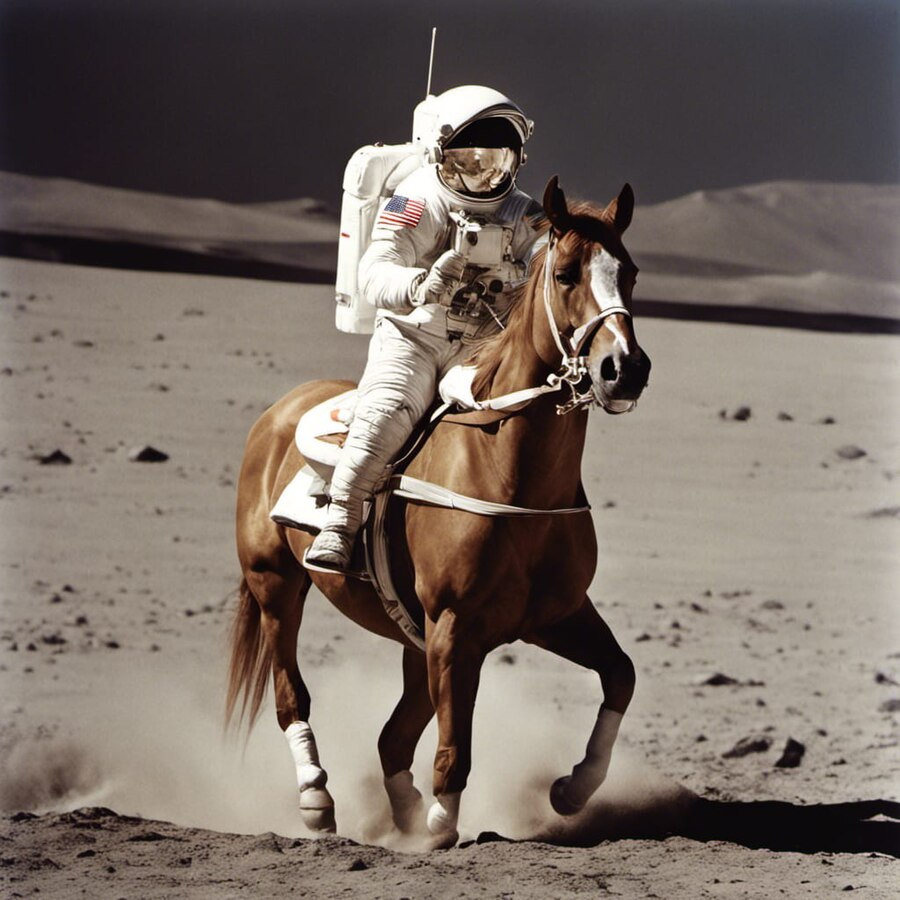

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Hyperparameters
img_size = 32
batch_size = 512
max_steps = 1000
lr = 1e-3
epochs = 1000

# モデルを書き換える
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.layers = nn.Sequential(
                            nn.Conv2d(1,32, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,32, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,32, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,32, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,32, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,32, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,1, kernel_size=3, padding=1)
                        )

            
    def forward(self, x):
        return self.layers(x)

    
def prepare_dataset(batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    # Load FashionMNIST Dataset
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def show_images(images, rows=2, cols=10):
    _, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

def diffusion_process_and_show_images(scheduler, model):
    # Diffusion Process
    model.eval()
    with torch.no_grad():
        samples = torch.randn((20, 1, img_size, img_size), device=device)
        for _, t in tqdm(enumerate(scheduler.timesteps)):
            samples = scheduler.step(model(samples), t, samples).prev_sample
    show_images([sample[0] for sample in samples])        

def save_checkpoint(epoch, model, optimizer, loss_avg):
    checkpoint_path = f"data/FashionMNIST/checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_avg,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")
        
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: Epoch {epoch}, Loss: {loss}")
    return epoch, loss

def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Prepare dataset
dataloader = prepare_dataset(batch_size)

# Initialize model
model = UNet().to(device)

# Scheduler for Diffusion
scheduler = DDPMScheduler(num_train_timesteps=max_steps)

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

start_epoch = 0
# Load Checkpoint path if needed
# checkpoint_path = "data/FashionMNIST/checkpoint_epoch_274.pth"
# if os.path.exists(checkpoint_path):
#    start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)

# Training loop
losses = []
for epoch in range(start_epoch, epochs):
    model.train()
    loss_sum = 0.0
    cnt = 0
    for images, lbls in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)

        # Randam time step
        t = torch.randint(0, max_steps, (len(x),), device=device)  

        # Add noise to images
        noise = torch.randn_like(x)
        noisy_images = scheduler.add_noise(x, noise, t)            

        # Predict noise
        noise_pred = model(noisy_images)

        # Back Propagation
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

    save_checkpoint(epoch, model, optimizer, loss_avg)
    plot_losses(losses)

    # Generate and visualize samples with last batch
    diffusion_process_and_show_images(scheduler, model)

# Save model
model.save_pretrained("data/FashionMNIST/")
